# Mock for Song

Ran with MDPL. Were able to match the SMF. But with that bestfit, clustering was way off - ~5x more clustering in HSC than in the sim.

Now trying with SMDPL from the UM - this should have better clustering because the UM tracks disrupted halos. (It doesn't - we probably have a bug)

**Bugs to check**

1) One of our clustering estimates is wrong. (no, corrfunc and halotools argree in the theory case and corrfunc and my func agree in the obs case)

2) We are using MPc in one of theory/obs and MPc/h in the other (no cosmo.comovingDistance gives MPc/h and SMDPL distances are in MPc/h)
  **Actual bug** Nope! The SMF in the obs data is in MPC!

3) One of these is using different masses Msun vs Msun/h (does that matter because we match the SMF of the sim to whatever it is in the data)

4) **Actual bug** I wasn't computing the mass function correctly. I forgot to divide by the width of the mass bin. Unfortunately this pushed the clustering the wrong way...

## Import etc...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize
import emcee

import data as d
import likelihood as l
import plots as p
import clustering as c


from get_sm_for_sim import get_sm_for_sim, get_smf

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 12,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
})

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# Load data

In [5]:
sim_data = d.load_smdpl() # When switching you need to restart the kernel

In [6]:
obs_smf = d.load_smf()
gals = d.load_gals()

# Starting params from https://redwoodforest.slack.com/files/U5WT8PBKN/FDD17SXN0/image.png 
#params = [10**12.52, 10**10.91, 0.45, 0.6, 1.83] # m1, sm0, beta, delta, gamma
b_params = [12.52, 10.91, 0.6] # Fix beta and gamma
s_params = [-0.06, 1.08]

# array([12.4506438 , 10.88120647,  0.61182347, -0.0612849 ,  1.07830828])
# Best from mdpl but something is wrong with clustering
b_params = [12.4506438 , 10.88120647,  0.61182347]
s_params = [-0.0612849 ,  1.07830828]

## Sanity check data

Remember to change sim size to 1000
Remember to change sim size to 1000
Remember to change sim size to 1000
16.18672764832874 15.624999999999996


[None]

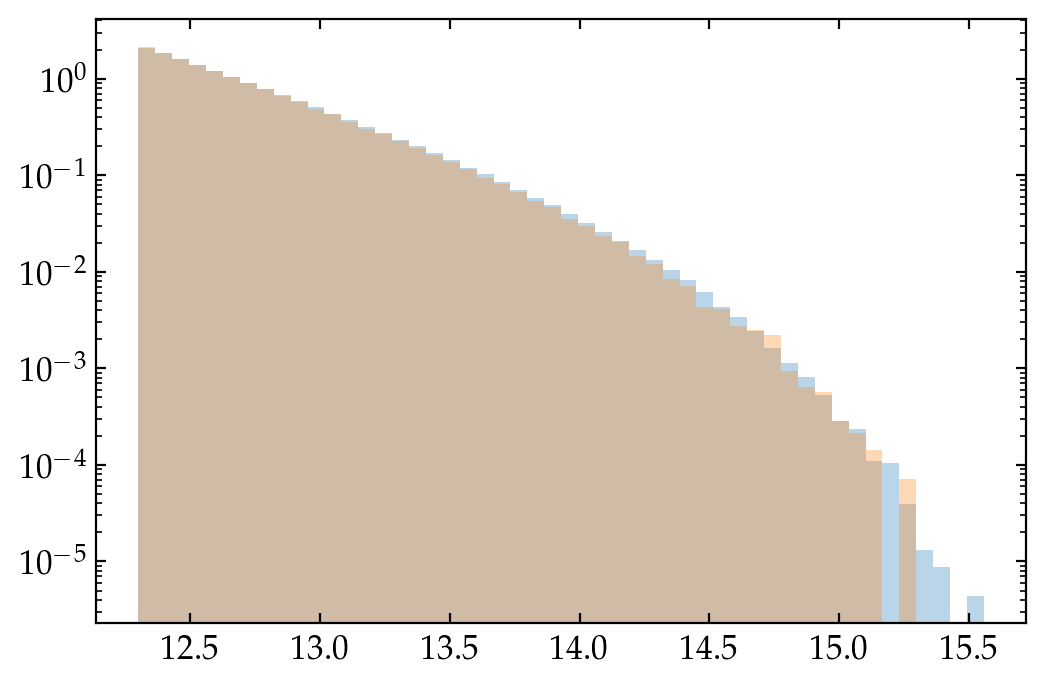

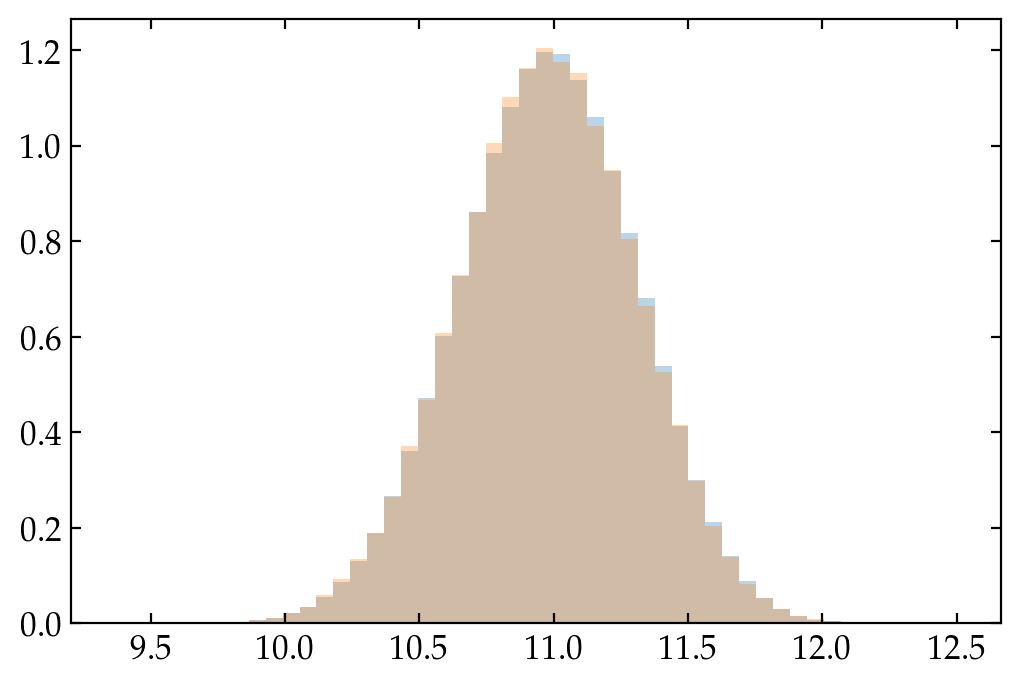

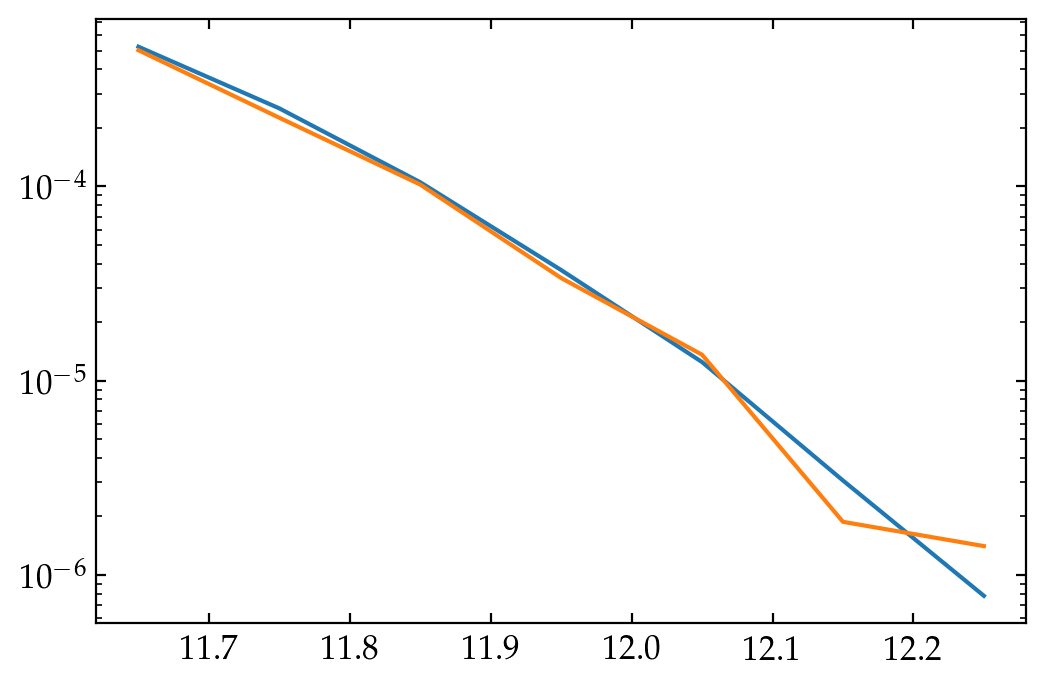

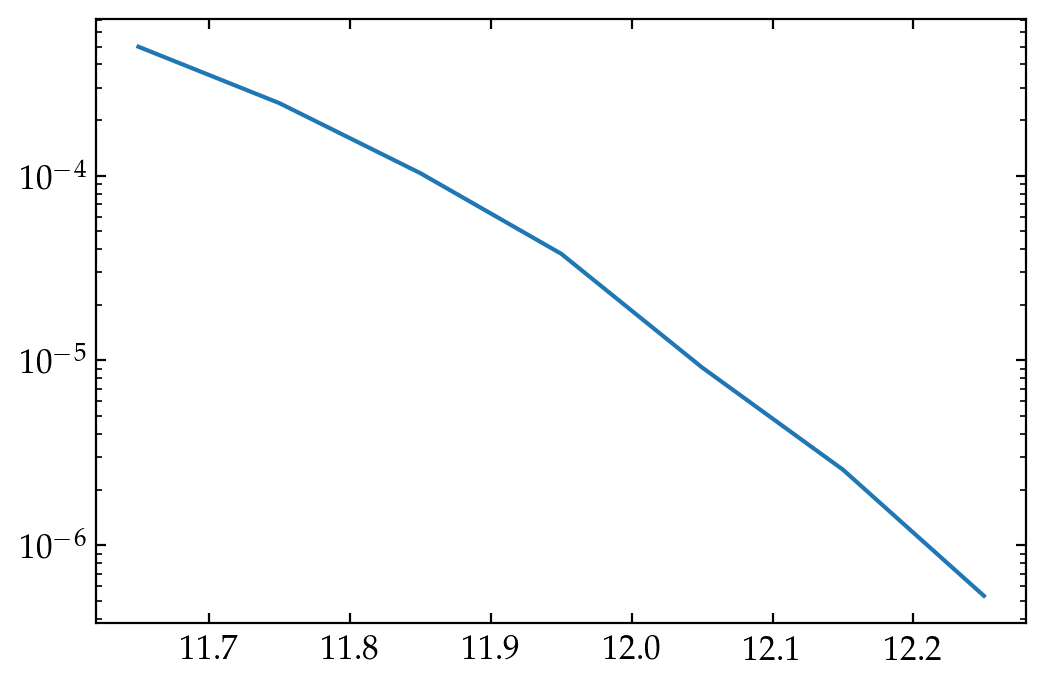

In [76]:
# Halo masses should be similar in smdpl and mdpl
_, ax = plt.subplots()
_, bins, _ = ax.hist(np.log10(d.load_mdpl(ignore_exception=True)["halo_mvir"]), bins=50, density=True, alpha=0.3)
ax.hist(np.log10(d.load_smdpl(ignore_exception=True)["halo_mvir"]), bins=bins, density=True, alpha=0.3)
ax.set(yscale="log")

# Stellar masses should be similar
mdpl_sm = get_sm_for_sim(d.load_mdpl(ignore_exception=True), b_params, s_params)
smdpl_sm = get_sm_for_sim(d.load_smdpl(ignore_exception=True), b_params, s_params)

_, ax = plt.subplots()
_, bins, _ = ax.hist(mdpl_sm, bins=50, density=True, alpha=0.3)
ax.hist(smdpl_sm, bins=bins, density=True, alpha=0.3)

# The SMF should be similar
sm_bins = np.linspace(11.6, 12.3, 8)
sm_bin_centers = (sm_bins[:-1] + sm_bins[1:]) / 2

_, ax = plt.subplots()
ax.plot(sm_bin_centers, get_smf(mdpl_sm, sm_bins, 1000**3))
ax.plot(sm_bin_centers, get_smf(smdpl_sm, sm_bins, 400**3))
ax.set(yscale="log")

# The ratio of the number of galaxies should be similar to the ratio of volumes
print(len(d.load_mdpl(ignore_exception=True)) / len(d.load_smdpl(ignore_exception=True)), 1 / 0.4**3)

# Smf should be quite a bit larger than 1e-4 at 11.6 (different to fig 4 https://arxiv.org/pdf/1707.01904.pdf)
_, ax = plt.subplots()
plt.plot(obs_smf["logm_mean"], obs_smf["smf"])
ax.set(yscale="log")

# MCMC the params

I don't think we actually want to do this - we want an optimizer

In [43]:
nwalkers = 64
params = b_params + s_params
ndim = len(params)
start_positions = np.array([params * (np.random.random(size=ndim)/20 + 0.975) for i in range(nwalkers)]) # peturbed best fit positions

sampler = emcee.EnsembleSampler(nwalkers, ndim, l.single_step, args=[sim_data, obs_smf], threads=32)
_ = sampler.run_mcmc(start_positions, 100) # Roughly 30s per step

negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatt

In [ ]:
sampler.run_mcmc(None, 1500)

## Plot MCMC

49.961758023056426
[12.33361471 11.06954566  0.59570586 -0.0612304   1.06639163]
[12.52, 10.91, 0.6] [-0.06, 1.08]


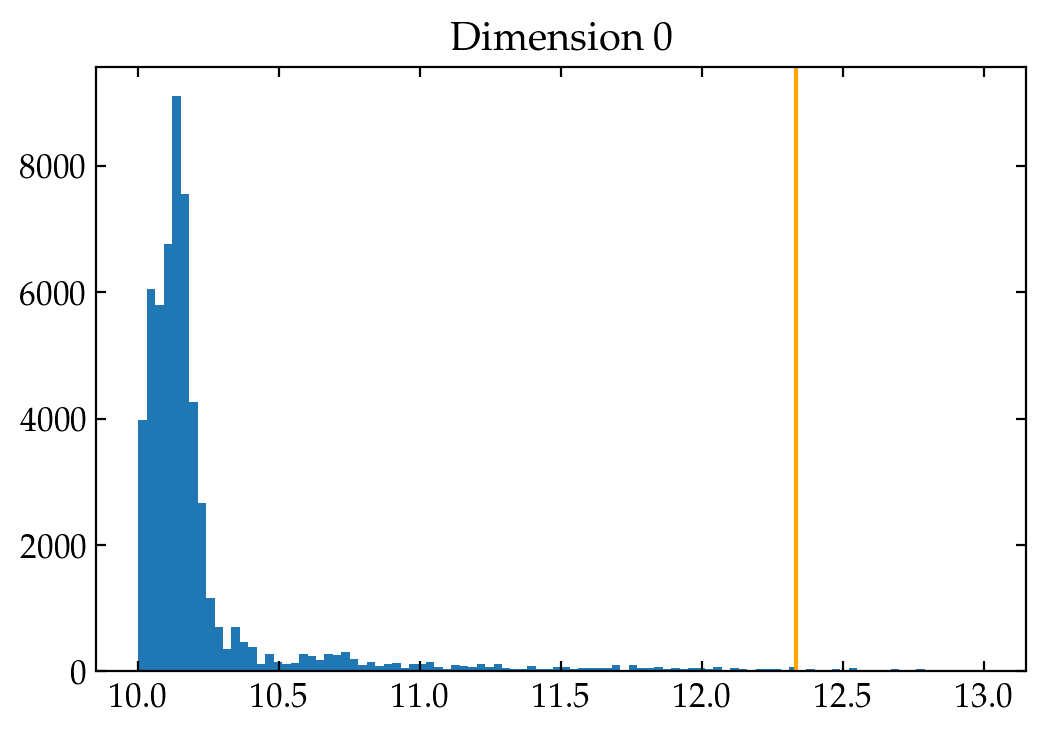

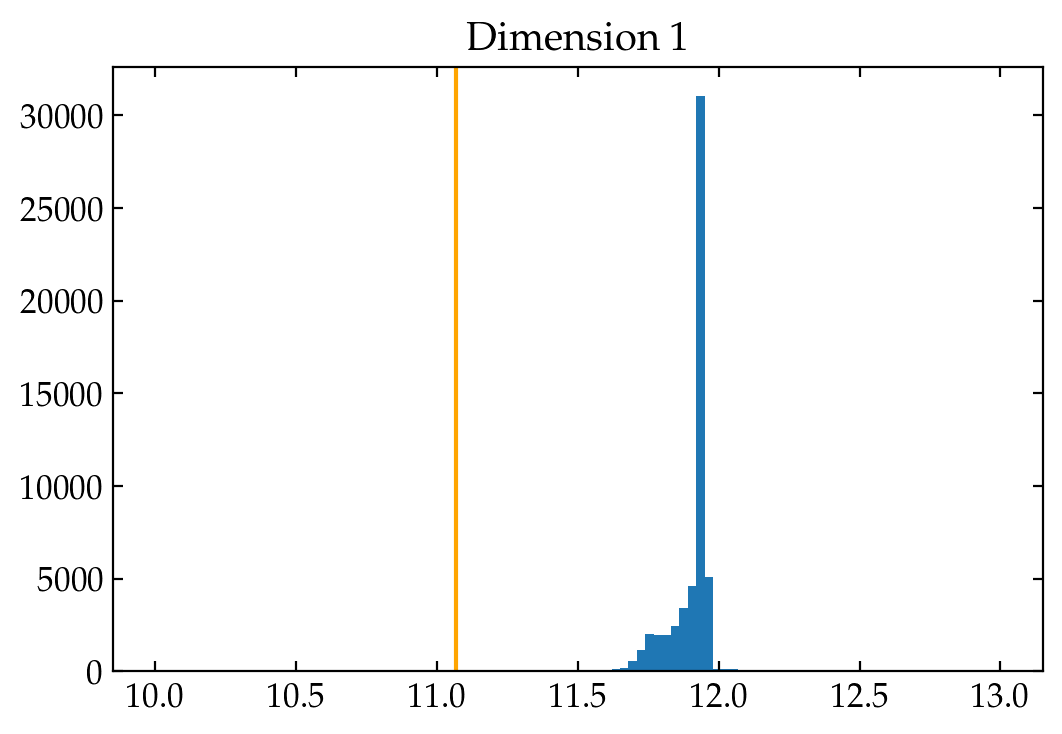

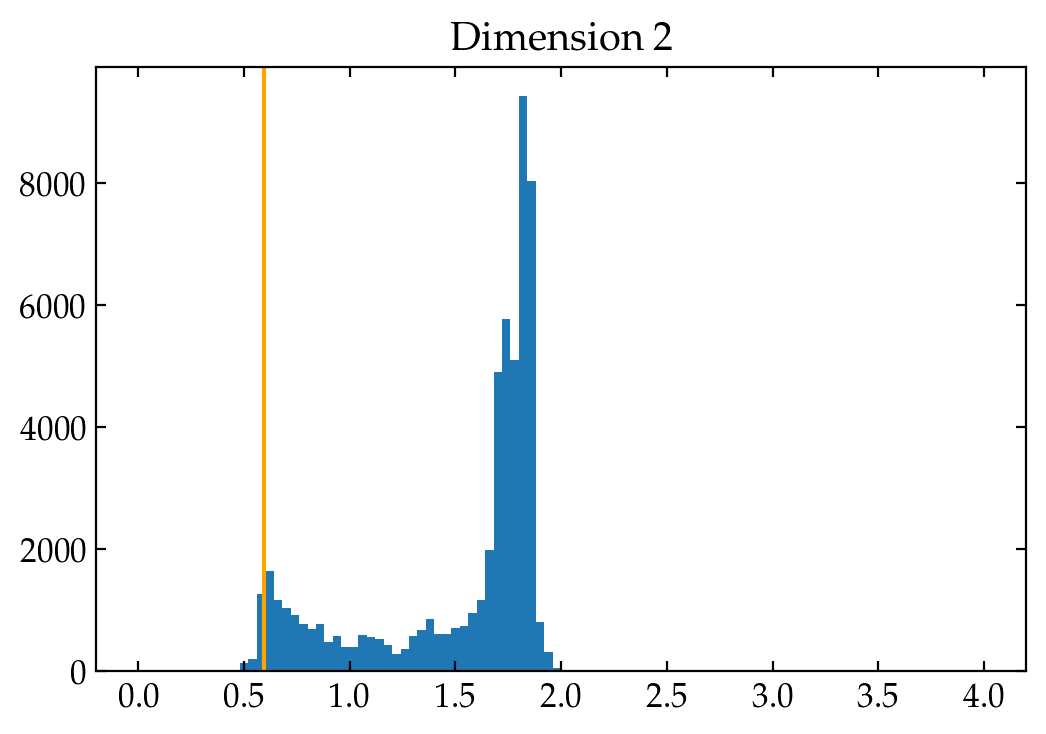

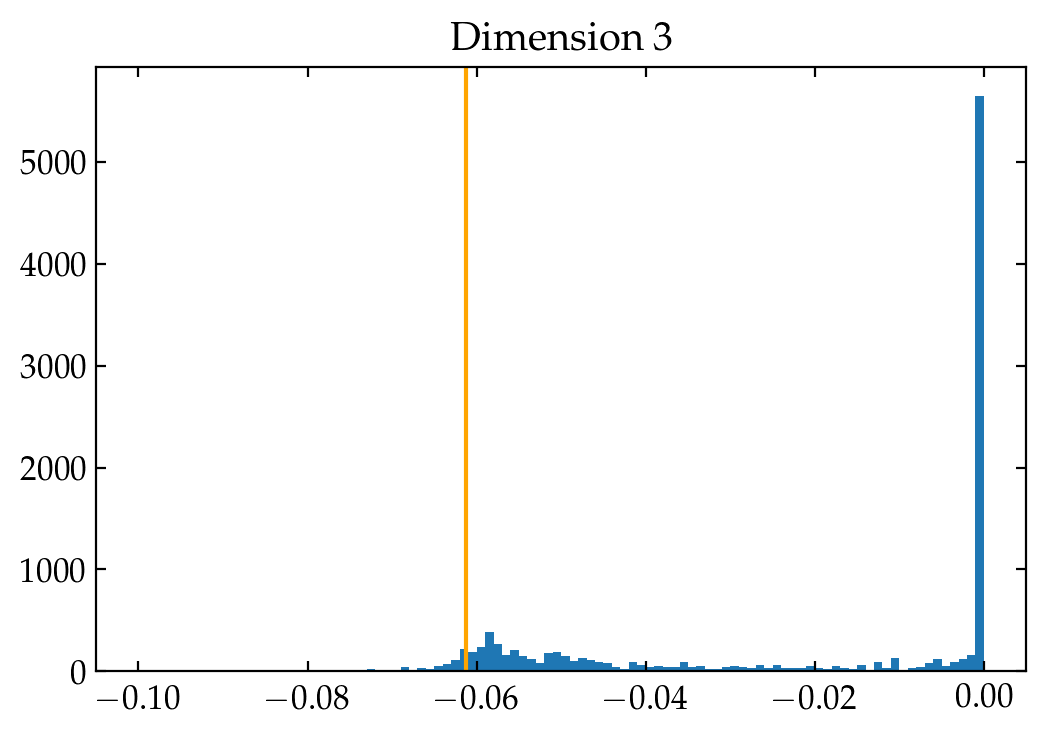

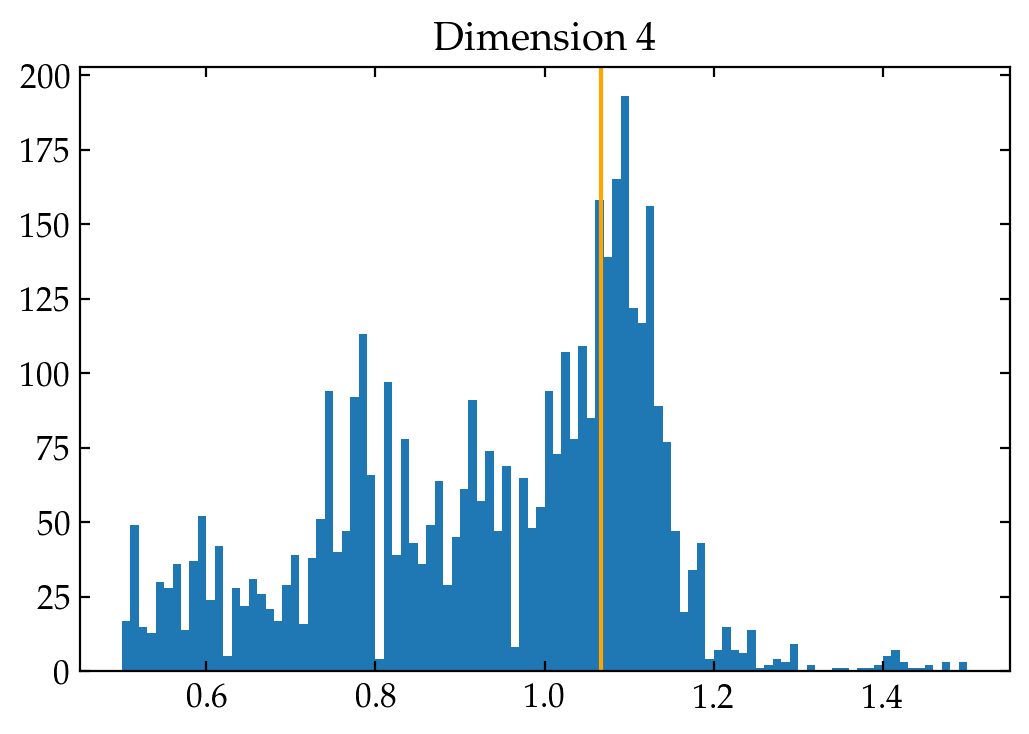

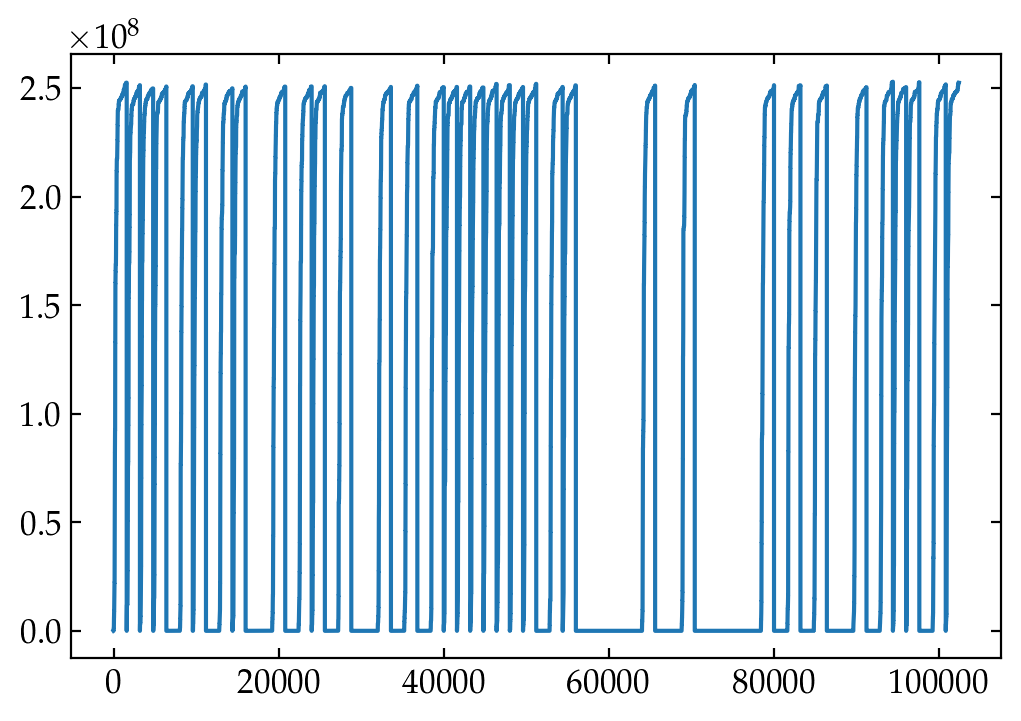

In [65]:
best_p = sampler.flatchain[
    sampler.flatlnprobability == np.min(sampler.flatlnprobability)
][0]
print(np.min(sampler.flatlnprobability))
print(best_p)
print(b_params, s_params)

ranges =[(10, 13), (10, 13), (0, 4), (-0.1, 0), (0.5, 1.5)]
for i in range(ndim):
    _, ax = plt.subplots()
    ax.hist(sampler.flatchain[:,i], bins=100, range=ranges[i])
    #ax.plot(sampler.chain[3,:,i])
    ax.set(title="Dimension {0:d}".format(i))
    ax.axvline(best_p[i], color="orange")

_, ax = plt.subplots()
ax.plot(sampler.flatlnprobability)

# Find bestfit to SMF with optimizer

In [7]:
params = b_params + s_params
res = scipy.optimize.minimize(
    l.single_step_avg,
    x0 = params,
    args=(sim_data, obs_smf, 3),
    method="Nelder-Mead",
    #tol=1,
)
assert res.success == True

[12.4506438  10.88120647  0.61182347 -0.0612849   1.07830828]
1.9793485633924657
[13.07317599 10.88120647  0.61182347 -0.0612849   1.07830828]
336.36731607876396
[12.4506438  11.42526679  0.61182347 -0.0612849   1.07830828]
477896.67081096815
[12.4506438  10.88120647  0.64241464 -0.0612849   1.07830828]
3.7028415276603823
[12.4506438  10.88120647  0.61182347 -0.06434915  1.07830828]
116.80564267985045
[12.4506438  10.88120647  0.61182347 -0.0612849   1.13222369]
567.8082149886295
[12.69965668 10.33714615  0.62405994 -0.0625106   1.09987445]
416.28970072926705
[12.79926183 10.66358234  0.62895453 -0.06300088  1.03301933]
416.43871682057056
[12.71210732 10.71798837  0.62467176 -0.06257188  1.05782042]
399.88703414022575
[12.55522921 11.35997955  0.61696279 -0.06179969  1.04854697]
69780.33634738612
[12.66354981 10.5928545   0.62228565 -0.06233287  1.08704258]
401.2324509879897
[12.59133607 11.1042712   0.61873708 -0.06197742  1.06137884]
1043.651961805849
[12.64549638 10.72070867  0.6213

0.7227344209521248
[12.45993445 10.89381643  0.62516334 -0.06125814  1.07724242]
1.4867468335561078
[12.46131473 10.89459618  0.62548469 -0.06125747  1.07718258]
1.1791730298623622
[12.46128979 10.89458458  0.62546623 -0.06125619  1.07718375]
1.8048573499116591
[12.46061296 10.89421768  0.6253357  -0.06125585  1.07720858]
1.5348887386602168
[12.45987263 10.89371544  0.62529803 -0.06125507  1.07724238]
1.9013068741462487
[12.4609355  10.8943673   0.62542418 -0.06125591  1.0771984 ]
2.094939517727764
[12.46052195 10.89405989  0.62546345 -0.06125335  1.07721586]
1.094116246868404
[12.46124408 10.89449353  0.62542053 -0.06125622  1.07718921]
1.7359791534563975
[12.46055394 10.89410366  0.62525985 -0.06125656  1.07721913]
2.0511916349651496
[12.4608932  10.89430428  0.62534603 -0.06125541  1.07720221]
2.6010507885069036
[12.46123161 10.89448774  0.6254113  -0.06125558  1.07718979]
1.7290756797835902
[12.46099681 10.89431     0.62541857 -0.06125526  1.07720172]
2.815706059543711
[12.4609191 

1.9270333961415351
[12.46109324 10.89433721  0.62534903 -0.0612547   1.07719924]
1.3788788054213945
[12.46109248 10.89433679  0.62534906 -0.0612547   1.07719927]
2.1784342336821587
[12.46109233 10.89433672  0.62534898 -0.0612547   1.07719927]
1.7426262245777326
[12.46109195 10.89433653  0.62534927 -0.06125469  1.07719928]
2.196679501815423
[12.46109255 10.89433683  0.62534904 -0.0612547   1.07719926]
1.6122896837178722
[12.46109332 10.89433723  0.62534872 -0.0612547   1.07719924]
1.3223480165078334
[12.46109313 10.89433715  0.62534879 -0.0612547   1.07719925]
2.564036880762996
[12.46109264 10.89433688  0.62534899 -0.0612547   1.07719926]
1.469660853464313
[12.46109341 10.89433729  0.62534888 -0.0612547   1.07719924]
0.8614930381305573
[12.46109352 10.89433736  0.62534876 -0.0612547   1.07719923]
1.1795663201208197
[12.46109379 10.8943375   0.62534871 -0.0612547   1.07719923]
0.7176953654283503
[12.4610934  10.89433729  0.62534854 -0.06125471  1.07719925]
1.1357203184817213
[12.46109335

1.8705445976492123
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9113178121782128
[12.46109257 10.89433686  0.62534886 -0.0612547   1.07719927]
1.0981184842982321
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9821674622243914
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.2645172549547368
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.746308230356691
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9787257802920049
[12.46109257 10.89433686  0.62534886 -0.0612547   1.07719927]
1.3777758375738351
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
3.2866109847605784
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.117152853933721
[12.46109257 10.89433686  0.62534886 -0.0612547   1.07719927]
1.7960242522262124
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.4361896831563936
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
3.1625083834186243
[12.4610925

1.9944515290259943
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9772016567222013
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.4246456971512353
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.3747169731122015
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
0.9130810179216312
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.6179629245511733
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5494565726719036
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.6145176155163352
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.1480886248480429
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.6147123498033367
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.880064810727527
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.8036606282749883
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.0980153136374449
[12.461092

2.748719154822526
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
0.8207856876933551
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5437051583280514
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.6986672808884293
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.2075779663098671
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.479100897938674
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.485744977147439
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.1169947908571143
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.3338754577681378
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.677567413269729
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.0631581243228907
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.571814486398184
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.2467937754376344
[12.46109258 1

1.7943253256747251
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
0.9614524075478582
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.071818735402313
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.3253079449053151
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.228084415958621
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.4955878172371786
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.0919353925109374
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.3950974839091497
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.0565678436325883
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.1876227129235235
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.0634386496854573
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.6740701006434138
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.8228636573470247
[12.4610925

2.047638366328962
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9905596578924822
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5455637105420512
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.2080780920713332
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.1284253666814414
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.899733206778988
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.3496373572658422
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.0468573586572212
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.0985556191074797
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5489206941130123
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.49189755681802
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.041413038802303
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5191064703838446
[12.46109258 1

2.0778362386215306
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5519849156651748
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.1773553194781115
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9067970455222227
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
0.9568195368026989
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9752639669388952
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.1002547315930036
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9192837470934594
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5479106040434722
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.420293135666914
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.3278380114137602
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
0.8320640546968434
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.9649601757704256
[12.461092

1.2958032986326333
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.120480849631848
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.2784845325426053
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.763041025380657
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.1079544452191301
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.2130993336399383
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.6721418294620396
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
2.670371772223683
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.5846660083981703
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.6165221141492534
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.138001831388083
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
1.4105536020517278
[12.46109258 10.89433686  0.62534886 -0.0612547   1.07719927]
0.9245572631589126
[12.46109258 

AssertionError: 

> /home/christopher/research/satellite_fraction/cb/plots.py(11)plot_smfs()
-> log_stellar_masses = get_sm_for_sim(sim_data, b_params, s_params)
(Pdb) c
0.7813946250337354


/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


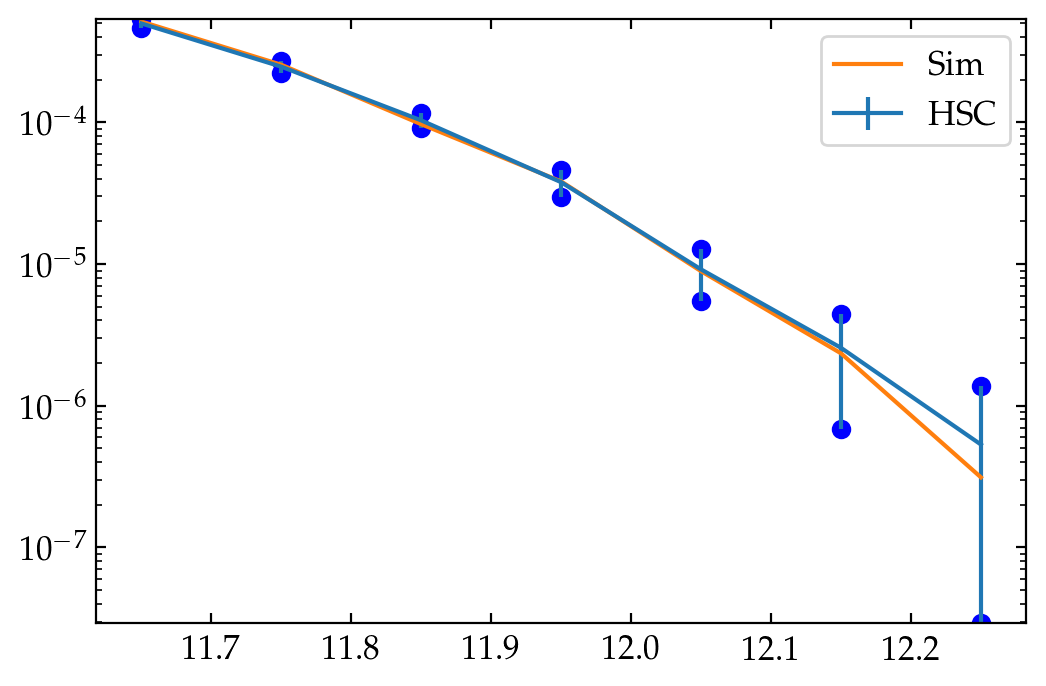

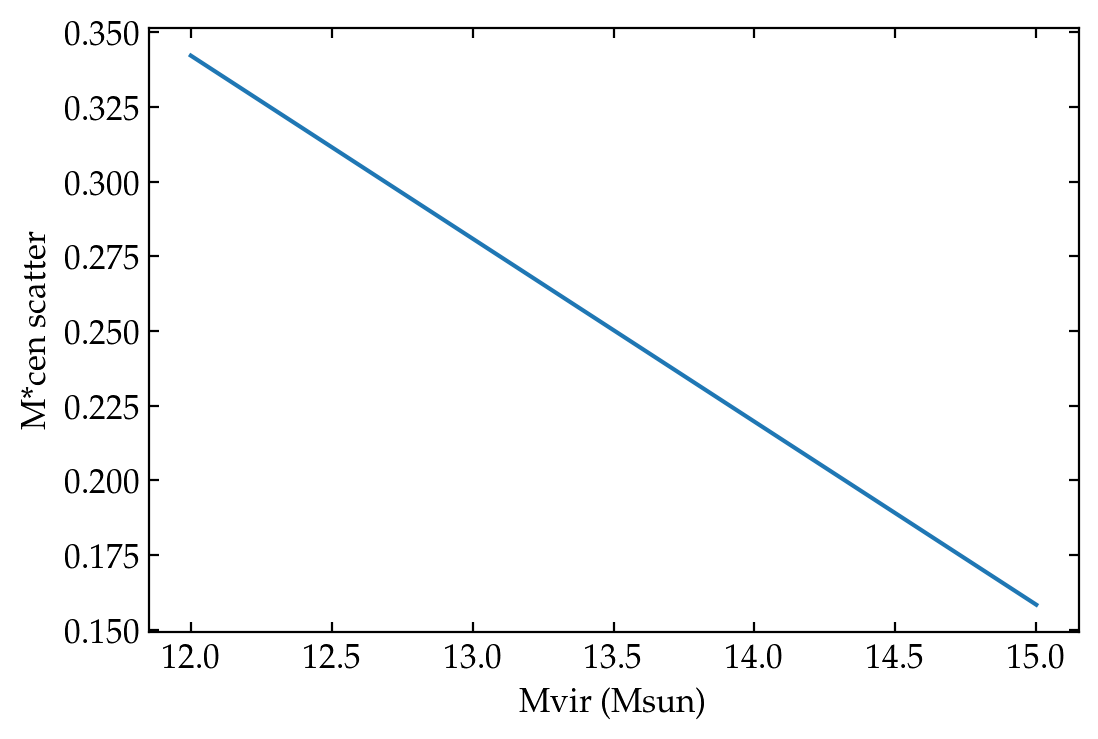

In [9]:
best_p = res.x
#best_p = [12.4506438 , 10.88120647,  0.61182347, -0.0612849 ,  1.07830828]
p.plot_smfs(sim_data, obs_smf, best_p[:3], best_p[3:])
p.plot_scatter(best_p[3:])

# Compute and Compare Clustering

In [10]:
lower_mass_cut = 11.65
upper_mass_cut = 11.75

## In HSC

In [11]:
randoms = d.load_randoms()
randoms = np.random.choice(randoms, 50000) # 1 in 10 just to make things quicker while in dev

s1 = gals[gals["logm_max"] > upper_mass_cut]
s2 = gals[
    (gals["logm_max"] > lower_mass_cut) & (gals["logm_max"] < upper_mass_cut)
]

# We need to ensure that the randoms have the same redshift distribution as s2
hist, edges = np.histogram(s2["z_best"], bins=100)
cdf = np.append(0, np.cumsum(hist))
cdf = cdf / cdf[-1]
f = scipy.interpolate.interp1d(cdf, edges)
randoms["z_best"] = f(randoms["z_best"])

dd = c.obs_clustering(s1, s2)
dr = c.obs_clustering(s1, randoms)

obs_clust = c.compute_clustering(dd, dr, len(s2), len(randoms))
print(obs_clust)

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/Corrfunc/mocks/DDrppi_mocks.py:348: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warn('One or more input array has non-native endianness!  A copy will be made with the correct endianness.')


28.09658647363565


## In the sim

In [12]:
log_stellar_masses = get_sm_for_sim(sim_data, best_p[:3], best_p[3:])

s1 = sim_data[log_stellar_masses > upper_mass_cut]
s2 = sim_data[(log_stellar_masses > lower_mass_cut) & (log_stellar_masses < upper_mass_cut)]
randoms = d.sim_size * np.random.random(size=(5_000_000, 3))
randoms = randoms.ravel().view([("halo_x", np.float64), ("halo_y", np.float64), ("halo_z", np.float64)])

dd = np.sum(c.sim_clustering(s1, s2))
dr = np.sum(c.sim_clustering(s1, randoms))
obs_clust = c.compute_clustering(dd, dr, len(s2), len(randoms))
print(obs_clust)

/home/christopher/research/satellite_fraction/cb/clustering.py:12: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  s1[["halo_x", "halo_y", "halo_z"]].view((np.float64, 3)),
/home/christopher/research/satellite_fraction/cb/clustering.py:13: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  s2[["halo_x", "halo_y", "halo_z"]].view((np.float64, 3)),


10.502335357488748


## Tests

In [ ]:
_, ax = plt.subplots()
_, bins, _ = ax.hist(log_stellar_masses[log_stellar_masses > 11.6], density=True, alpha=0.3)
ax.hist(gals["logm_max"][gals["logm_max"] > 11.6], density=True, bins=bins, alpha=0.3)
ax.set(yscale="log")

# Cluster finder